In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plta
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange
from tqdm.notebook import tqdm
import nibabel as nib
import imageio
from matplotlib import pyplot as plt
import pathlib
from torch.utils.data import DataLoader,Dataset

In [2]:
#scp junyi@zfl01:/data01/junyi/datasets/HCP_100/100307/T1w/Diffusion/FA_MNI.nii.gz ~/Desktop

In [3]:
img_data_dir = '/data01/junyi/datasets/HCP_100'
dir_list = sorted(list(pathlib.Path(img_data_dir).iterdir()))[:20]

In [4]:
# gpus_list = ''
# for i in range(torch.cuda.device_count()):
#     used,all=torch.cuda.mem_get_info(device=i)
#     if used/all >=0.80:
#         gpus_list+=f'{i},'

# gpus_list[:-1]

In [5]:
paths = list(pathlib.Path('/data01/junyi/datasets//HCP_100').glob('**/FA*'))

In [10]:
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',
                   'SLF_I', 'SLF_II', 'SLF_III', 'STR',
                   'ST_FO', 'ST_OCC', 'ST_PAR', 'ST_POSTC', 'ST_PREC', 'ST_PREF', 'ST_PREM',
                   'T_OCC', 'T_PAR', 'T_POSTC', 'T_PREC', 'T_PREF', 'T_PREM', 'UF']
# backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
#                    'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',]
len(backbone_tracts)

34

In [7]:
def crop(x,indice_down, indice_up):
    x = x.astype(np.float32)
    return x[indice_down[0]:indice_up[0],indice_down[1]:indice_up[1],indice_down[2]:indice_up[2]]
class FiberDatasetDir(Dataset):
    def __init__(self, img_data_dir: pathlib.Path, transform=None, ):

        self.img_data_dir = sorted(list(pathlib.Path(img_data_dir).iterdir()))[:2]
        self.transform = transform
        tmp = nib.load(list(self.img_data_dir[0].glob('**/FA_MNI*'))[0])
        self.config = (tmp.affine,tmp.header)
        self.shape = tmp.get_fdata().shape

    def __len__(self):
        return len(self.img_data_dir)

    def __getitem__(self, idx):
        images_dir_path = self.img_data_dir[idx]
        struct_dict = {}
        indice_down = np.array(self.shape)//2-np.array([128//2, 160//2, 128//2])
        indice_up =(np.array(self.shape)//2)+np.array([128//2, 160//2, 128//2])
        FA_path = sorted(list(images_dir_path.glob('**/FA_MNI*')))[0]
        struct_dict['FA'] = self.transform(nib.load(FA_path).get_fdata()[::-1],indice_down,indice_up)[np.newaxis, ...]
            

        for tract in backbone_tracts:
            TOM_path = sorted(list((images_dir_path/'T1w/Diffusion/tractseg_output/TOM_new/').glob(f'{tract}.nii.gz')))[0]
            struct_dict[tract] = self.transform(nib.load(TOM_path).get_fdata()[::-1],indice_down,indice_up).transpose(-1,0,1,2)
        
        return struct_dict

In [11]:
vol_shape = (128, 160, 128)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
atlas = torch.empty(3, *vol_shape)
TOM_models = {}
for tract in backbone_tracts:

    # snapshot_path = f'snapshot1_{tract}.pt'
    # snapshot = torch.load(snapshot_path,map_location='cpu')
    TOM_models[tract] = networks.TemplateCreation(vol_shape,atlas,nb_unet_features=[enc_nf, dec_nf],altas_feats=3,src_feats=3)
    # TOM_models[tract].load_state_dict(snapshot["MODEL_STATE"])
# altas = model.atlas.squeeze().detach().numpy().transpose(1,2,3,0)

In [13]:
atlas = torch.normal(1,1e-5, (1,*vol_shape))
snapshot_whole_path = f'/data01/junyi/models/models_sep/snapshot20_alltracts_whole.pt'
snapshot = torch.load(snapshot_whole_path,map_location='cpu')
model = networks.WholeModel(vol_shape,atlas,TOM_models,nb_unet_features=[enc_nf, dec_nf],altas_feats=1,src_feats=1,use_TOM=False,FA_only=False)
model.load_state_dict(snapshot["MODEL_STATE"])

<All keys matched successfully>

In [14]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)


In [15]:
nib.save(nib.Nifti1Image(model.FA_model.atlas.detach().squeeze().numpy()[::-1], dataset.config[0], dataset.config[1]),f'atlas1.nii.gz')

In [ ]:
model.FA_model.atlas.squeeze().shape

torch.Size([128, 160, 128])

In [ ]:
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_VISIBLE_DEVICES=0,1


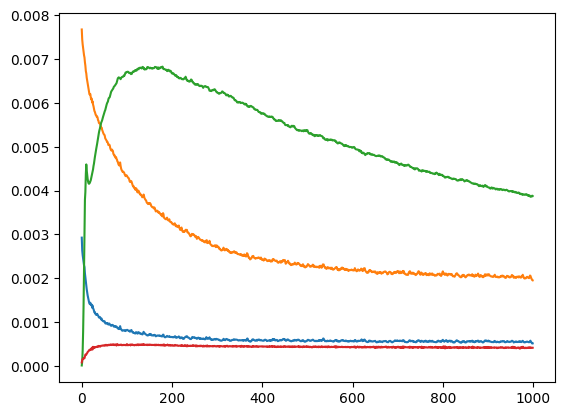

In [18]:
plt.plot(snapshot['LOSS_HIS'])

In [10]:
def _run_batch(model,optimizer,source,target):
    loss_funcs, loss_weights= _set_loss_function(model)
    optimizer.zero_grad()
    y_pred = model(source)
    loss = torch.stack([loss_funcs[i](target[i],y_pred[i])*loss_weights[i] for i in range(len(loss_weights))])
    loss.sum().backward()
    optimizer.step( )
    torch.cuda.empty_cache()
    return loss

def _set_loss_function(model):
    image_loss_func = nn.MSELoss()
    # orient_loss_func = nn.CosineSimilarity()
    # pos_loss_func = lambda y_true, y_pred: 1-torch.mean(orient_loss_func(y_true,y_pred))
    # neg_loss_func = lambda _,y_pred: 1-torch.mean(image_loss_func(y_pred, torch.stack([self.model.module.atlas for _ in range(y_pred.shape[0])])))
    pos_loss_func = lambda _,y_pred: image_loss_func(y_pred, torch.stack([model.FA_model.atlas for _ in range(y_pred.shape[0])]))
    neg_loss_func = lambda y_true_dict,y_pred_dict: torch.mean(torch.stack([image_loss_func(y_pred,y_true_dict[key]) for key,y_pred in y_pred_dict.items()]))
    mean_flow_loss = lambda _,y_pred: torch.square(y_pred).mean()
    loss_funcs = [pos_loss_func,neg_loss_func,mean_flow_loss, vxm.losses.Grad('l2', loss_mult=2).loss]
    loss_weights = [0.5, 0.5, 0.1, 0.01]
    return loss_funcs, loss_weights


In [ ]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)
# data = next(iter(DataLoader(dataset,batch_size=1,num_workers=8)))

In [12]:
with torch.no_grad():
    model.eval()
    model(data,registration=True)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(grid, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = grid.transpose(1,2,0)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    

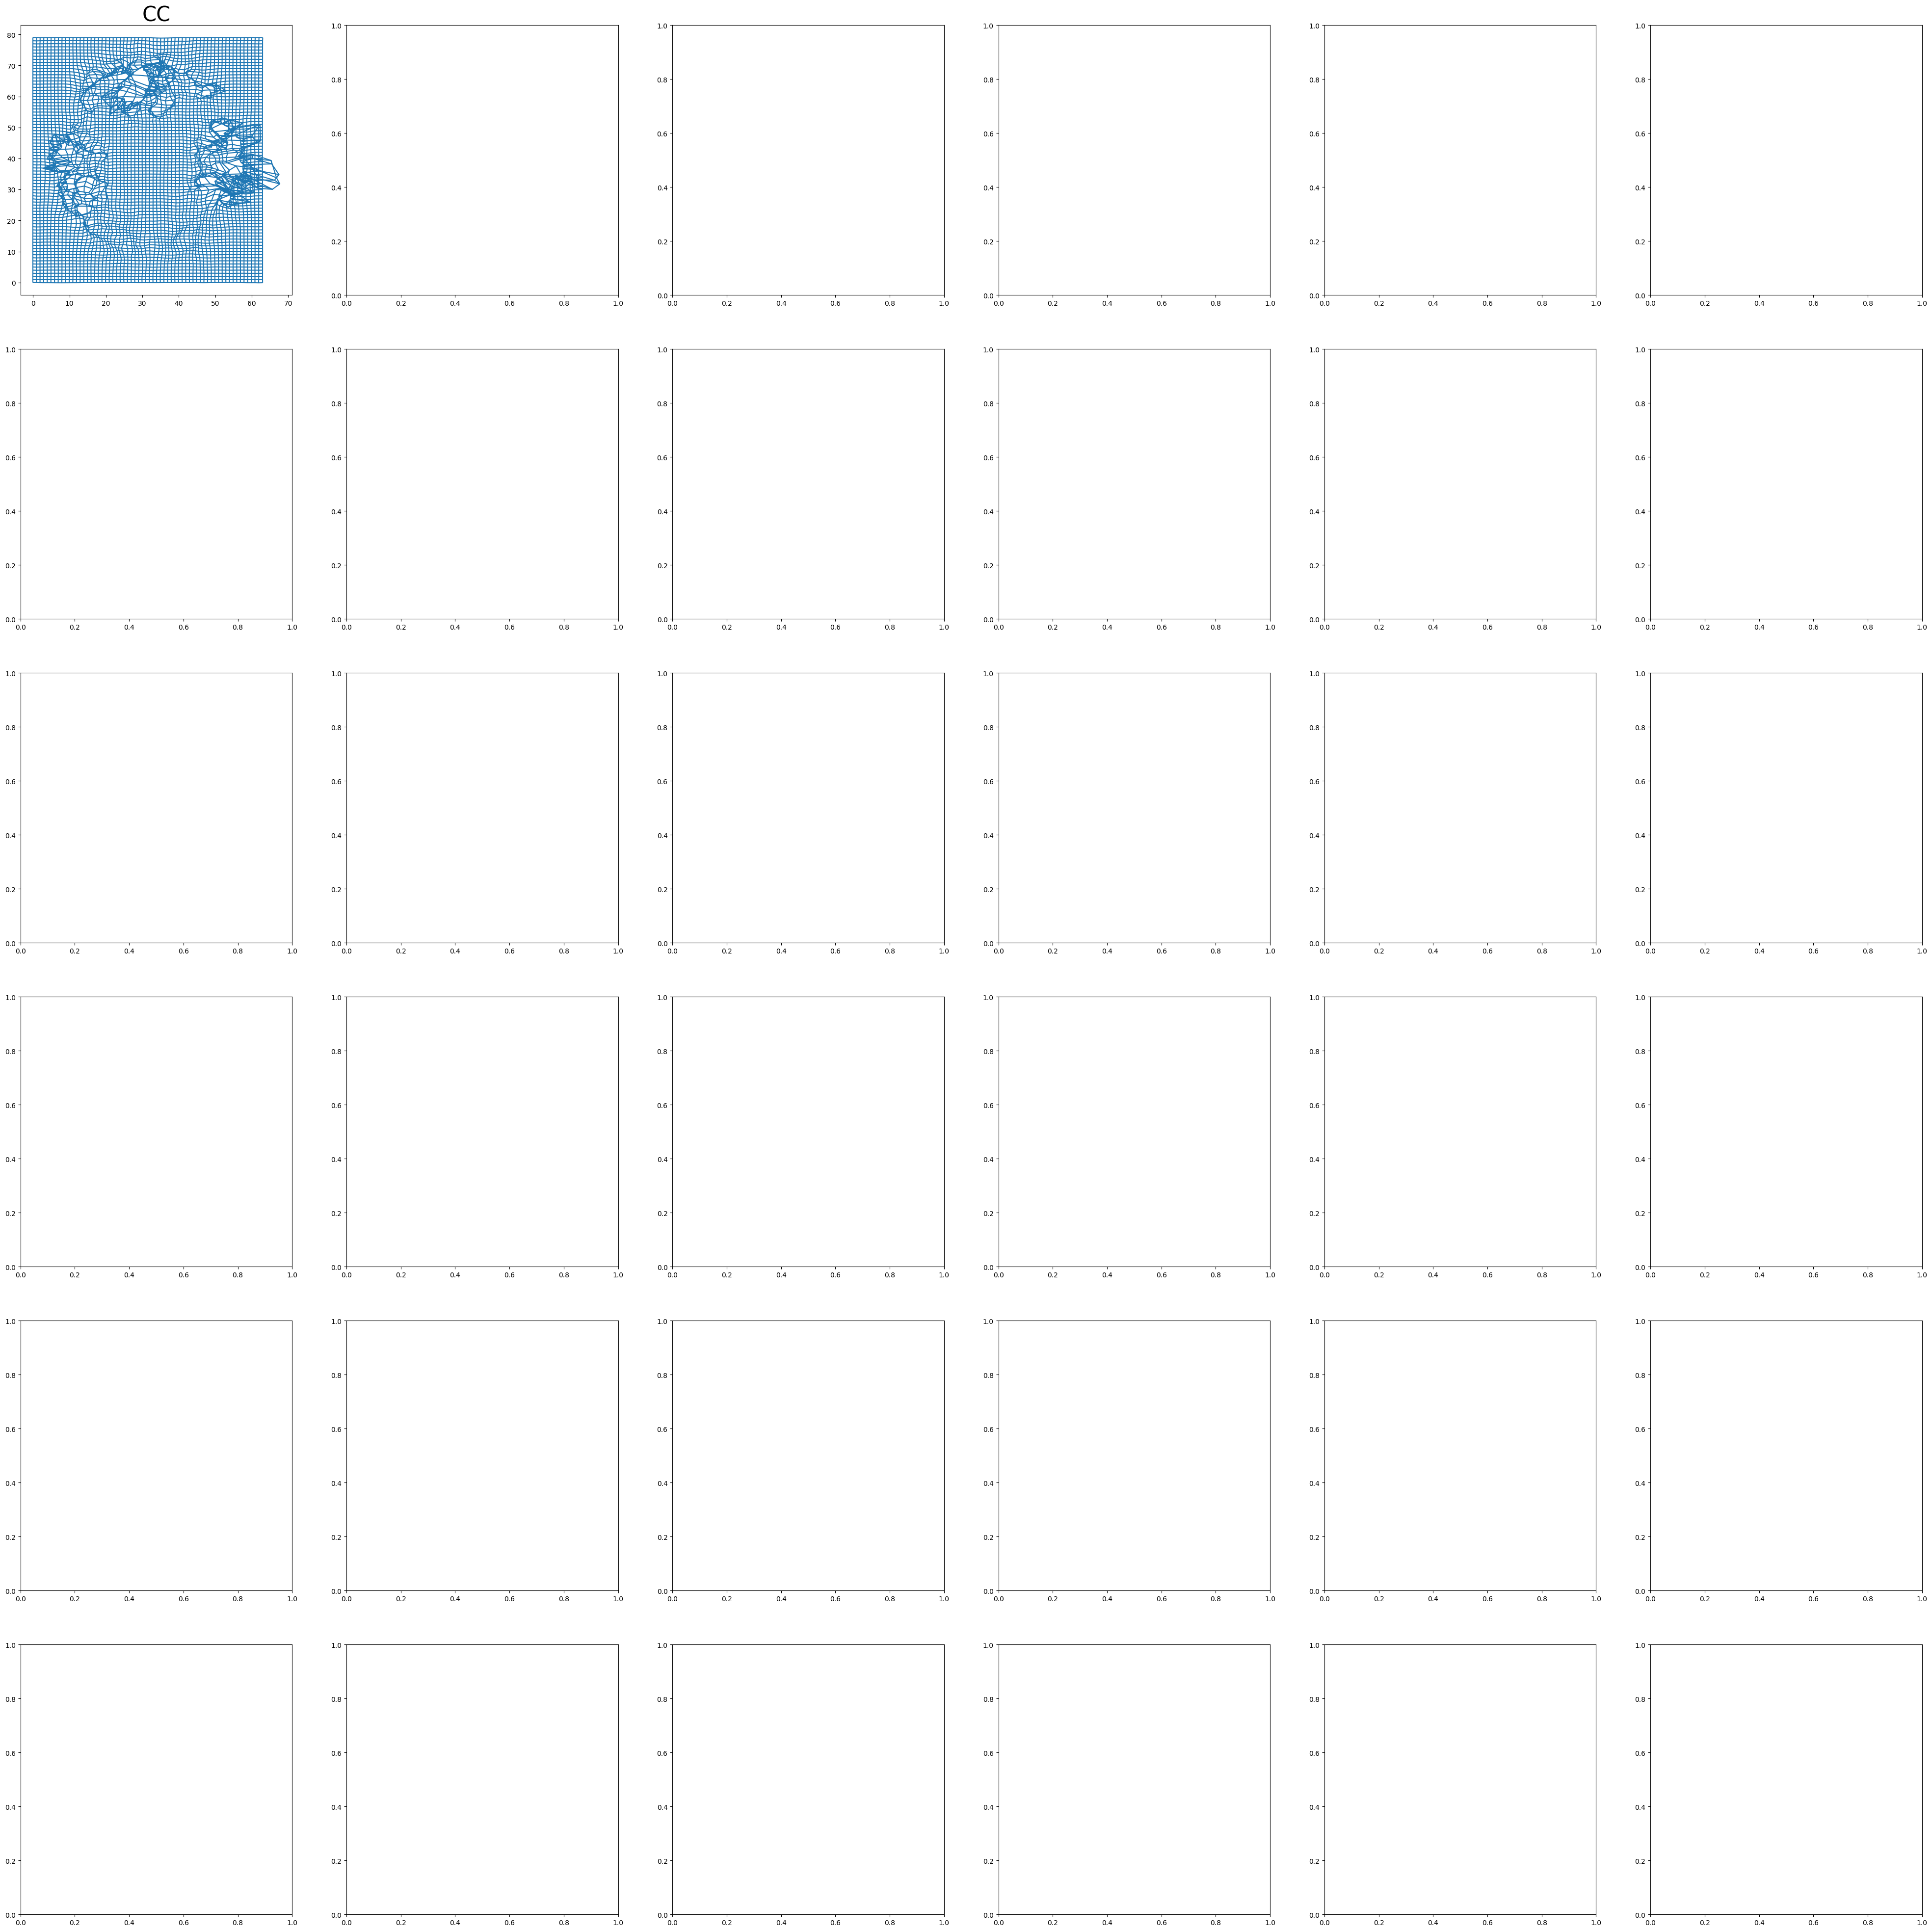

In [16]:
x,y = torch.meshgrid([torch.arange(64),torch.arange(80)],indexing='ij')

fig , axes = plt.subplots(6,6,figsize=(50,50))

axes = axes.reshape(-1)
for i, flows in enumerate(model.flow_TOMs):
    grid_shift = flows[0,:2,...,20].cpu()+torch.stack([x,y])
    plot_grid(grid_shift.detach().numpy(),axes[i])
    axes[i].set_title(backbone_tracts[i],size=30)
    if i >=33:
        break
plt.savefig('abc.png')